In [1]:
from os import path
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from capstoneFunctions import create_db_connection, read_query
from capstoneFunctions import mined_stock_close, add_close_series, match_close
from capstoneFunctions import moneyness, bs_cost
from capstoneFunctions import data_one_std
from capstoneFunctions import rounding, xavier_init, binary_sampler,uniform_sampler,sample_batch_index
from capstoneFunctions import gain

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


---

# Account Retrieval

---

# <div style ="color:red">!!!</div>

In [2]:
# acct info, move to file (php? txt?) and import
acct = 'flatiron'
pwd = 'flatiron'
db = 'stock'

# <div style ="color:red">!!!</div>

---

# Data Selection

---

Import the options data:

In [3]:
work_data = 'options.csv'
# sql command to import options data
get_opts = """
select * from options;
"""
# execute command to create csv of options data
connection = create_db_connection('localhost',acct,pwd,db)

# check for more efficient way to do this
# creates csv file of working data set, otherwise creates df from working set
if path.exists(work_data):
    opts_df = pd.read_csv(work_data)
else:
    opts, cols = read_query(connection, get_opts)
    opts_df = pd.DataFrame(opts)
    opts_df.columns = cols
    opts_df.to_csv(work_data, index=False)

connection.close()

MySQL Database connection successful


In [4]:
# convert dates to dateTime objects
dt_to_convert = ['expDate','mineDate']
for col in dt_to_convert:
    opts_df[col] = pd.to_datetime(opts_df[col], format='%Y/%m/%d')

---

# Cleaning, Feature Generation

---

In [5]:
opts_df.head()

,strike,lastPrice,volume,impliedVolatility,inTheMoney,ticker,expDate,mineDate,call,time_to_exp,close,moneyness,stk_cls_diff,bs_theory
0,1.0,2.50,12.0,4.500004,1,XXII,2021-04-16,2021-04-01,1,15.0,3.48,3.480,2.48,2.542289
1,2.0,1.51,29.0,1.625002,1,XXII,2021-04-16,2021-04-01,1,15.0,3.48,1.740,1.48,1.496448
2,3.0,0.63,896.0,1.335941,1,XXII,2021-04-16,2021-04-01,1,15.0,3.48,1.160,0.48,0.639614
3,4.0,0.20,1100.0,1.406253,0,XXII,2021-04-16,2021-04-01,1,15.0,3.48,0.870,-0.52,0.212957
4,5.0,0.05,3325.0,1.468753,0,XXII,2021-04-16,2021-04-01,1,15.0,3.48,0.696,-1.52,0.066684


In [6]:
opts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195324 entries, 0 to 195323
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   strike             195324 non-null  float64       
 1   lastPrice          195324 non-null  float64       
 2   volume             195324 non-null  float64       
 3   impliedVolatility  195324 non-null  float64       
 4   inTheMoney         195324 non-null  int64         
 5   ticker             195324 non-null  object        
 6   expDate            195324 non-null  datetime64[ns]
 7   mineDate           195324 non-null  datetime64[ns]
 8   call               195324 non-null  int64         
 9   time_to_exp        195324 non-null  float64       
 10  close              195324 non-null  float64       
 11  moneyness          195324 non-null  float64       
 12  stk_cls_diff       195324 non-null  float64       
 13  bs_theory          195324 non-null  float64 

In [7]:
# justifiable as there is plenty of data and nulls are very small percentage 
# (for this set 12% lost but still almost 300000 datapoints total) 
opts_df.dropna(inplace=True)

Ensure data variety:

In [8]:
len(opts_df['ticker'].unique())

1569

In [9]:
opts_df['ticker'].value_counts().head(20)

AMZN     4575
QQQ      4376
GOOGL    3041
GOOG     2678
AAPL     2324
NVDA     2176
NFLX     2109
MELI     1945
BKNG     1807
MSFT     1735
TQQQ     1714
FB       1648
LRCX     1456
TLT      1330
BIDU     1313
AMD      1261
MSTR     1234
COST     1213
PYPL     1202
NVAX     1196
Name: ticker, dtype: int64

In [10]:
opts_df['ticker'].value_counts().tail()

CAC     1
AROW    1
OLMA    1
ACET    1
CRVL    1
Name: ticker, dtype: int64

In [11]:
opts_df.head(3)

,strike,lastPrice,volume,impliedVolatility,inTheMoney,ticker,expDate,mineDate,call,time_to_exp,close,moneyness,stk_cls_diff,bs_theory
0,1.0,2.50,12.0,4.500004,1,XXII,2021-04-16,2021-04-01,1,15.0,3.48,3.48,2.48,2.542289
1,2.0,1.51,29.0,1.625002,1,XXII,2021-04-16,2021-04-01,1,15.0,3.48,1.74,1.48,1.496448
2,3.0,0.63,896.0,1.335941,1,XXII,2021-04-16,2021-04-01,1,15.0,3.48,1.16,0.48,0.639614


In [12]:
# create a mineDate expirationDate difference column
opts_df['time_to_exp'] = (opts_df['expDate']-opts_df['mineDate']).astype('timedelta64[D]')

In [13]:
tickers_unique = opts_df['ticker'].unique()
mine_dates_unique = opts_df['mineDate'].unique()

In [14]:
# add close column to df if does not exist:
df_close_prep = pd.DataFrame()
df_close_prep['ticker'] = tickers_unique
df_close_prep['mineDates'] = np.full(len(tickers_unique),mine_dates_unique)


# this is a very inefficient function
#    all that needs to be done is check the close price once for each ticker
#    (for this particular data set) and forwardfill
if 'close' not in opts_df.columns:
    close_col = df_close_prep.apply(add_close_series, axis=1)
    close_col.to_csv('close_col.csv', index=False)
else: 
    pass

<div style="color:teal">
Missing closing $$:
FOX
GSUM
OCSI
PEBO
ANH
ARLO
CHU
CTRA
</div>

<div style="color:teal">Based on the above information the decision has been made to drop the tickers with the missing closing price</div>

In [15]:
# add close column to options dataframe if it doesn't exist
if 'close' not in opts_df.columns:
    close_col = opts_df['ticker'].apply(match_close, args=(closings, '2021-04-01'))
    opts_df['close'] = close_col
    opts_df.to_csv('options.csv', index=False)
else:
    pass

<div style="color:teal">Currently the price features are not standardized. Options considered for standardization are proportions or distances. The distance approach would be to add a feature that differences strike price and underlying close price, whereas the proportion approach would just scale stike price over close price.</div><\br><\br>
<div>
Both strike-close difference and "Moneyness" have been decided as the features to generate. For calls moneyness is defined as the stock price / strike price and for puts strike price / stock price
</div>

In [16]:
if 'moneyness' or 'stk_cls_diff' not in opts_df.columns:
    moneyness = opts_df[['close','strike','call']].apply(moneyness, axis=1)
    opts_df['moneyness'] = moneyness
    opts_df['stk_cls_diff'] = opts_df['close']-opts_df['strike']
    opts_df.to_csv('options.csv', index=False)
else: 
    pass

<div style="color:teal">Analytical/Theoretical Exploration:<div>

<div style="color:teal">Black-Scholes theoretical options pricing for European calls/puts:<div>

<div style="color:#957dad">
$$
c = Se^{(b-r)t}N(d_1)-Xe^{-rt}N(d_2) \\
p = Xe^{-rt}N(-d_2) - Se^{(b-r)t}N(-d_1)
$$
</br></br>
<div style="color:teal">where</div>
$$
d_1 = \frac{ln(\frac{S}{X})+(b+\frac{\sigma^2}{2})t}{\sigma \sqrt{t}}\\
d_2 = \frac{ln(\frac{S}{X})+(b-\frac{\sigma^2}{2})t}{\sigma \sqrt{t}} = d_1 - \sigma\sqrt{t}\\
$$
</br></br>
<div style="color:teal">where</div></br>
<ul>
    <li>S is the current stock price</li>
    <li>X is the options strike price</li>
    <li>sigma is the implied volatility</li>
    <li>b is a generalized cost of carry parameter </br> -> (r - q) where r will be the three-month US Treasury bill rate (.02%->.0002) and q = 0</li>
    <li>t is the time to maturity in years</li>
    <li>N(x) is the cumulative normal distribution function:</li>
</ul>
$$
N(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{z=-\infty}^x{e^{-\frac{z^2}{2}}dx}
$$
</div>

Check to see how the bid/ask average (lastPrice) compares to B-S calculated price

In [17]:
if 'bs_theory' not in opts_df.columns:
    bs_rdy = opts_df[['close', 'strike', 'impliedVolatility','time_to_exp', 'call']]
    theor_cost = bs_rdy.apply(bs_cost, axis=1)
    opts_df['bs_theory'] = theor_cost
    opts_df.to_csv('options.csv', index=False)
else:
    pass

---

# Exploratory Analysis

---

In [18]:
opts_df.describe()

,strike,lastPrice,volume,impliedVolatility,inTheMoney,call,time_to_exp,close,moneyness,stk_cls_diff,bs_theory
count,195324.000000,195324.000000,195324.000000,195324.000000,195324.000000,195324.000000,195324.000000,195324.000000,195324.000000,195324.000000,195324.000000
mean,270.686439,32.268732,62.065297,0.829884,0.411480,0.552636,142.813198,295.801021,1.090566,25.114582,34.180165
std,587.535177,119.314813,719.704389,0.954227,0.492103,0.497223,177.268418,627.445749,1.592379,198.587480,126.031585
min,0.500000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.560000,0.002691,-2139.000000,0.000000
25%,25.000000,0.850000,1.000000,0.404059,0.000000,0.000000,15.000000,27.389999,0.739765,-9.619999,0.833553
50%,80.000000,4.280000,3.000000,0.593754,0.000000,1.000000,78.000000,88.940002,0.944778,1.570000,4.243044
75%,200.000000,17.660000,12.000000,0.957032,1.000000,1.000000,197.000000,217.259995,1.150957,21.599998,17.973952
max,5300.000000,2508.600000,121842.000000,97.000002,1.000000,1.000000,1814.000000,3161.000000,371.640015,2301.000000,2423.812213


<div style="color:teal">Potential nan_to_num situation with some of these min/max values</div>

In [19]:
corr = opts_df.corr(method='pearson')
corr.style.background_gradient(cmap='PRGn')

,strike,lastPrice,volume,impliedVolatility,inTheMoney,call,time_to_exp,close,moneyness,stk_cls_diff,bs_theory
strike,1.000000,0.441404,-0.001156,-0.141604,-0.014839,-0.014284,-0.001519,0.948672,-0.028336,0.038798,0.428559
lastPrice,0.441404,1.000000,-0.018487,-0.057716,0.237387,0.062912,0.141984,0.492134,0.103116,0.248996,0.959282
volume,-0.001156,-0.018487,1.000000,-0.025427,-0.023196,0.014098,-0.042304,-0.003850,-0.006223,-0.008746,-0.018721
impliedVolatility,-0.141604,-0.057716,-0.025427,1.000000,0.012476,-0.001648,-0.175258,-0.143500,0.064000,-0.034450,-0.060684
inTheMoney,-0.014839,0.237387,-0.023196,0.012476,1.000000,0.121621,0.025417,-0.007972,0.262389,0.018714,0.256404
call,-0.014284,0.062912,0.014098,-0.001648,0.121621,1.000000,0.018996,-0.046474,0.074223,-0.104576,0.075652
time_to_exp,-0.001519,0.141984,-0.042304,-0.175258,0.025417,0.018996,1.000000,0.013755,0.043059,0.047953,0.137556
close,0.948672,0.492134,-0.003850,-0.143500,-0.007972,-0.046474,0.013755,1.000000,-0.017453,0.352831,0.494700
moneyness,-0.028336,0.103116,-0.006223,0.064000,0.262389,0.074223,0.043059,-0.017453,1.000000,0.028690,0.119112
stk_cls_diff,0.038798,0.248996,-0.008746,-0.034450,0.018714,-0.104576,0.047953,0.352831,0.028690,1.000000,0.295105


In [20]:
# drop unnessesary columns
# moneyness contains the information for inTheMoney (moneyness > 1  is in the money and < 1 is not)
to_drop = ['expDate', 'mineDate', 'strike','ticker', 'inTheMoney']
cleaned_opts = opts_df.drop(columns = to_drop, axis = 1)
cleaned_opts

,lastPrice,volume,impliedVolatility,call,time_to_exp,close,moneyness,stk_cls_diff,bs_theory
0,2.50,12.0,4.500004,1,15.0,3.480000,3.480000,2.480000,2.542289e+00
1,1.51,29.0,1.625002,1,15.0,3.480000,1.740000,1.480000,1.496448e+00
2,0.63,896.0,1.335941,1,15.0,3.480000,1.160000,0.480000,6.396137e-01
3,0.20,1100.0,1.406253,1,15.0,3.480000,0.870000,-0.520000,2.129575e-01
4,0.05,3325.0,1.468753,1,15.0,3.480000,0.696000,-1.520000,6.668357e-02
...,...,...,...,...,...,...,...,...,...
195319,9.40,1.0,0.062509,0,295.0,95.900002,0.719499,26.900002,1.681379e-09
195320,11.05,47.0,0.737551,0,295.0,95.900002,0.729927,25.900002,1.086006e+01
195321,8.85,1.0,0.062509,0,295.0,95.900002,0.740355,24.900002,3.494255e-08
195322,10.40,1.0,0.062509,0,295.0,95.900002,0.750782,23.900002,1.411058e-07


In [21]:
# creating separate calls/puts dfs
calls_df = pd.DataFrame(cleaned_opts.loc[opts_df['call'] == True])
puts_df = pd.DataFrame(cleaned_opts.loc[opts_df['call'] == False])

calls_df.drop(columns=['call'], axis=0, inplace=True)
puts_df.drop(columns=['call'], axis=0, inplace=True)

## IV GAIN

In [22]:
iv = opts_df['impliedVolatility']
iv_zero = iv.loc[iv == 0]
len(iv_zero)

492

Not many values, but GAIN can be applied to future missing data

Couldn't get the GAIN function working properly, will continue to work on it in the future.

array([[<AxesSubplot:xlabel='lastPrice', ylabel='lastPrice'>,
        <AxesSubplot:xlabel='volume', ylabel='lastPrice'>,
        <AxesSubplot:xlabel='impliedVolatility', ylabel='lastPrice'>,
        <AxesSubplot:xlabel='time_to_exp', ylabel='lastPrice'>,
        <AxesSubplot:xlabel='close', ylabel='lastPrice'>,
        <AxesSubplot:xlabel='moneyness', ylabel='lastPrice'>,
        <AxesSubplot:xlabel='stk_cls_diff', ylabel='lastPrice'>,
        <AxesSubplot:xlabel='bs_theory', ylabel='lastPrice'>],
       [<AxesSubplot:xlabel='lastPrice', ylabel='volume'>,
        <AxesSubplot:xlabel='volume', ylabel='volume'>,
        <AxesSubplot:xlabel='impliedVolatility', ylabel='volume'>,
        <AxesSubplot:xlabel='time_to_exp', ylabel='volume'>,
        <AxesSubplot:xlabel='close', ylabel='volume'>,
        <AxesSubplot:xlabel='moneyness', ylabel='volume'>,
        <AxesSubplot:xlabel='stk_cls_diff', ylabel='volume'>,
        <AxesSubplot:xlabel='bs_theory', ylabel='volume'>],
       [<AxesSubpl

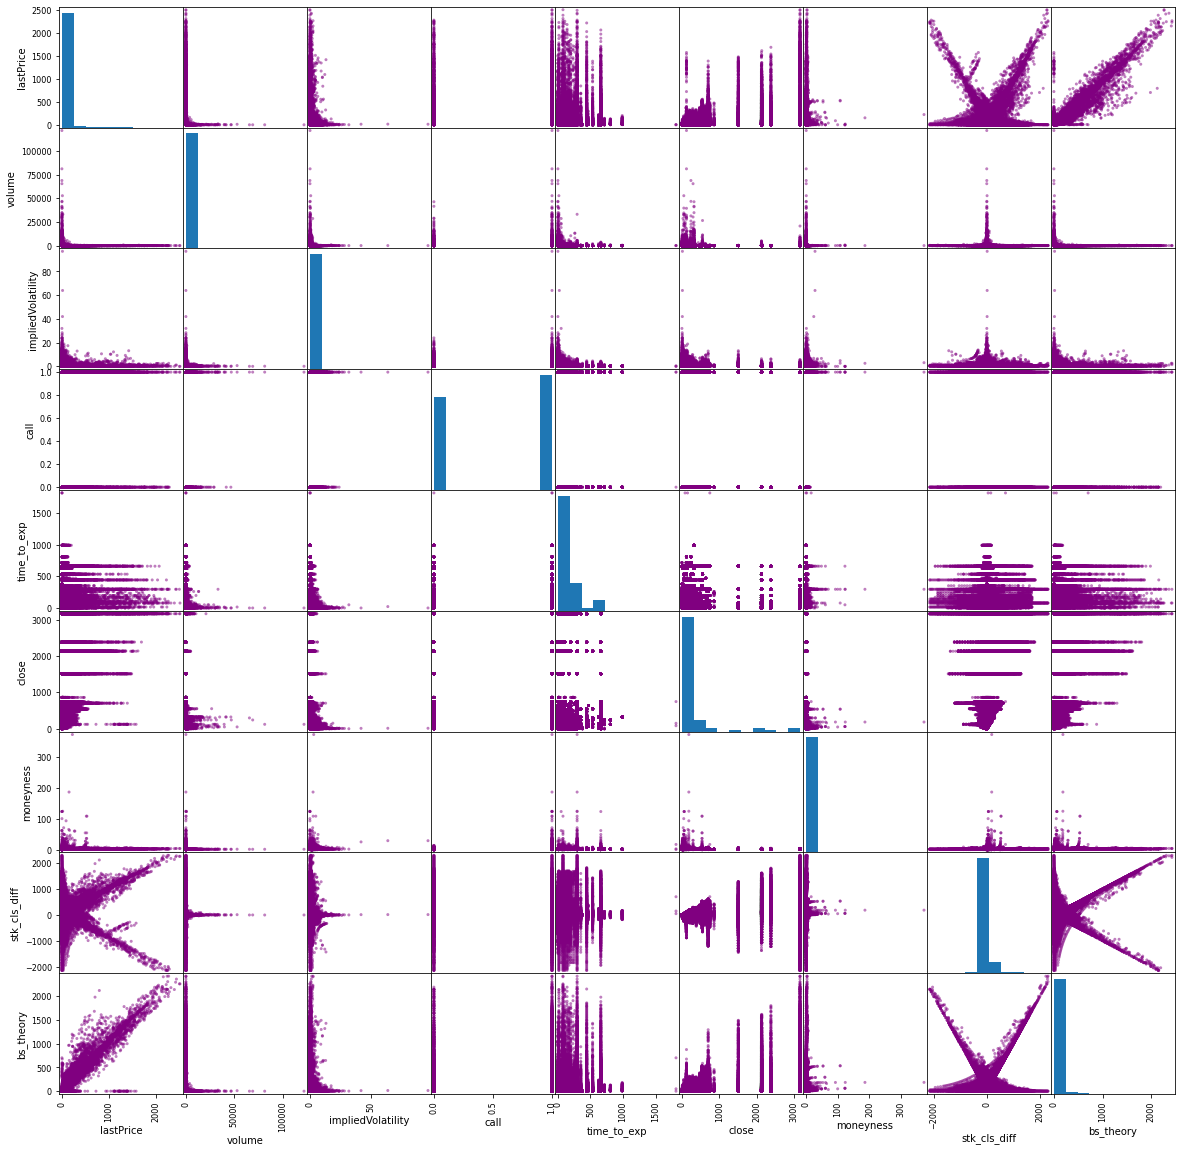

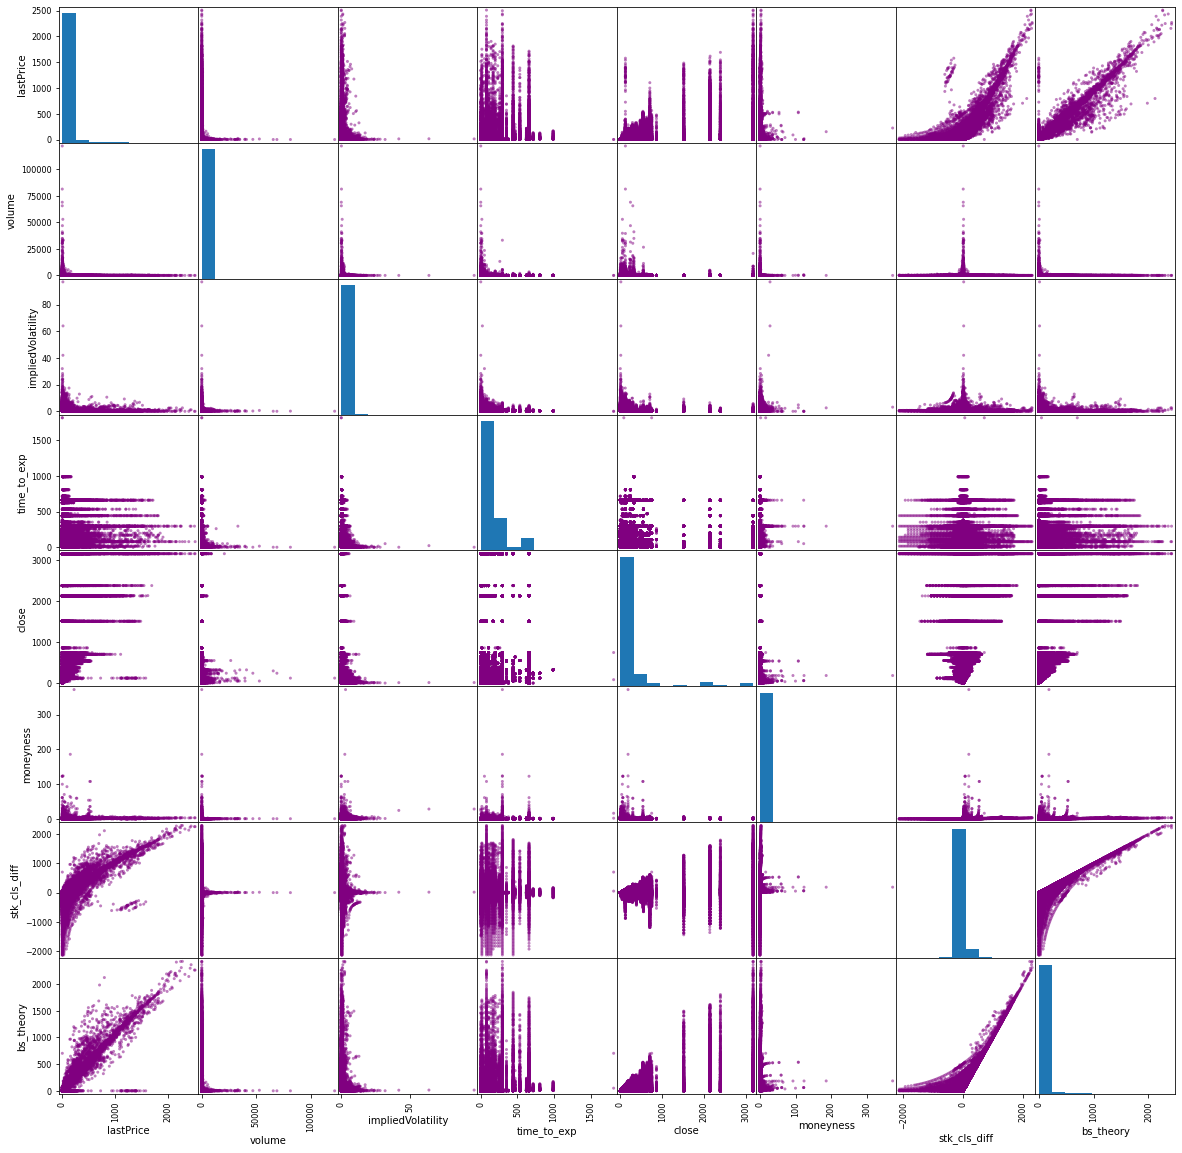

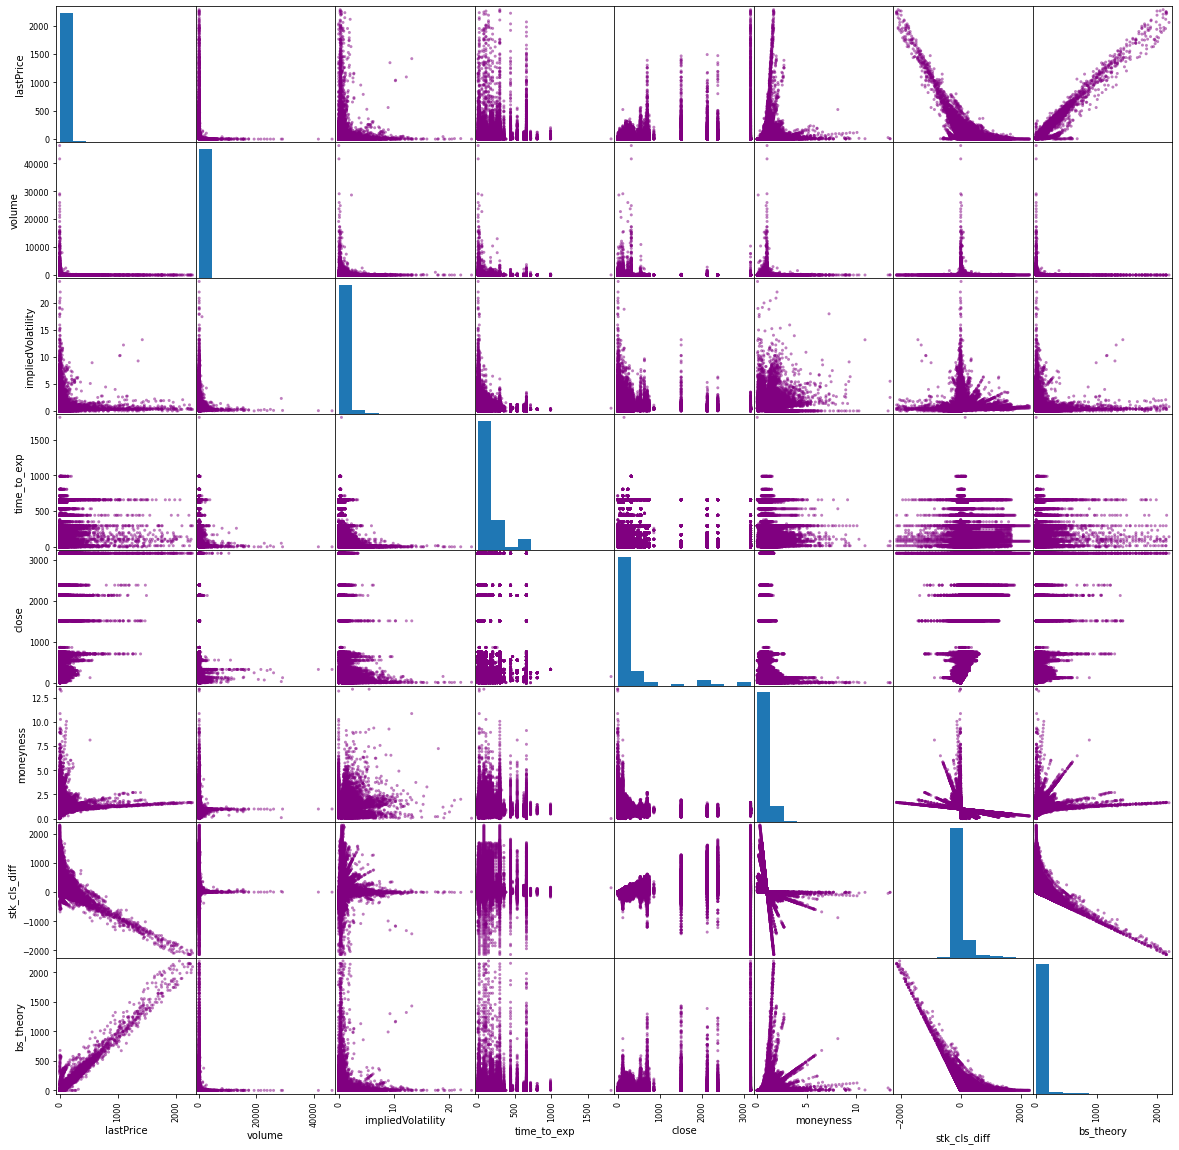

In [23]:
# Scatter_matrix saved as .png file in folder
scatter_matrix(cleaned_opts, figsize = (20,20), color='purple')
scatter_matrix(calls_df, figsize = (20,20), color='purple')
scatter_matrix(puts_df, figsize = (20,20), color='purple')

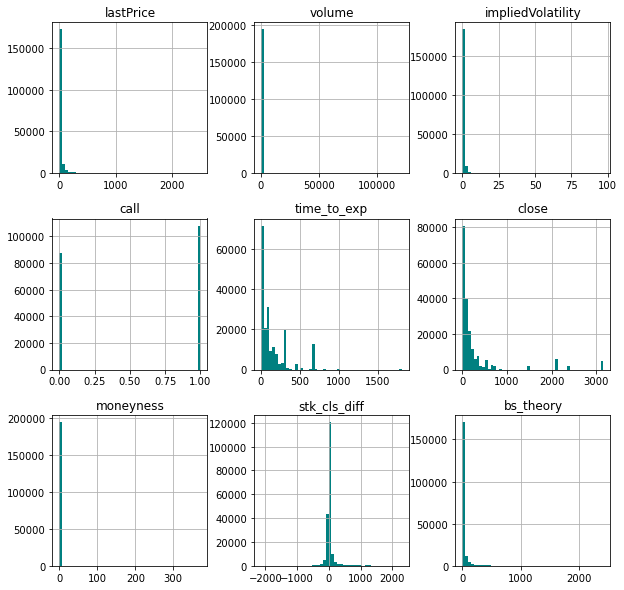

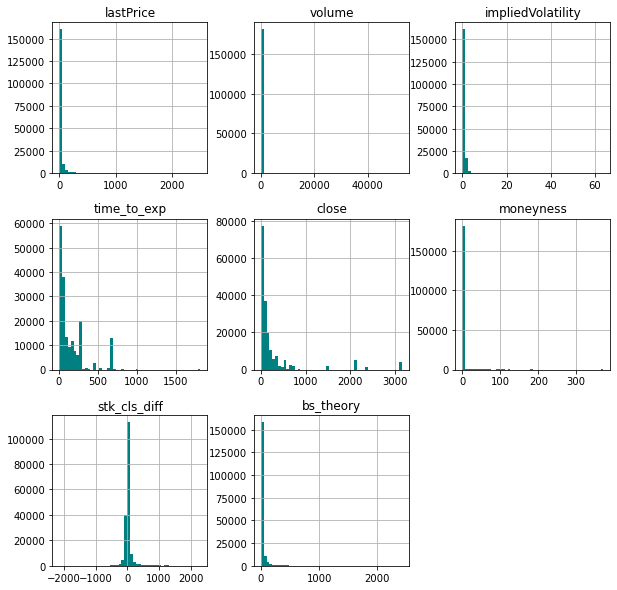

In [24]:
# options df histograms
cleaned_opts.hist(bins=50,figsize=(10,10), color='teal')

# log-transformed histograms
to_lt = cleaned_opts[['lastPrice','volume','impliedVolatility', 'time_to_exp','close','moneyness','stk_cls_diff','bs_theory']]
no_zero = to_lt.loc[(to_lt['volume'] > 0) & (to_lt['impliedVolatility'] > 0) & (to_lt['time_to_exp'] > 0) & (to_lt['bs_theory'] > 0)]
lt = np.log(no_zero)
no_zero.hist(bins=50,figsize=(10,10), color='teal')


plt.show()

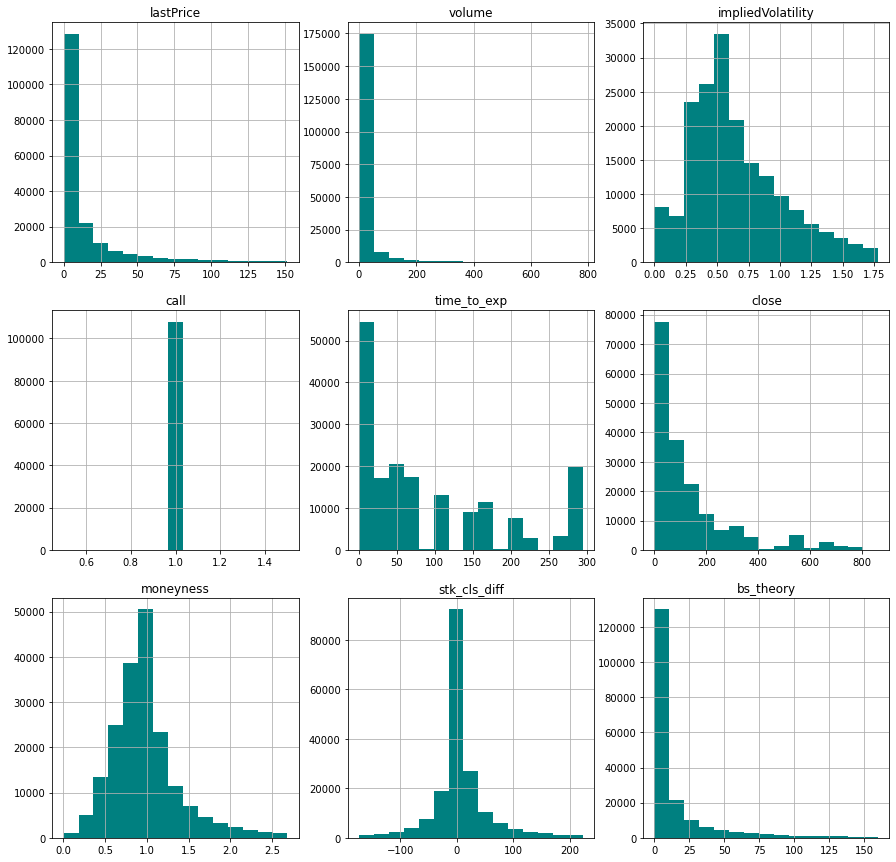

In [25]:
# outliers removed:
# for col in cleaned_opts.columns:
fig = plt.figure(figsize=(15,15))
for i in range(len(cleaned_opts.columns)):
    col = cleaned_opts.columns[i]

    plt.subplot(3,3,i+1)    
    
    pruned = data_one_std(cleaned_opts, col)
    pruned.hist(bins=15,color='teal')
    plt.title(col)
    
plt.show()

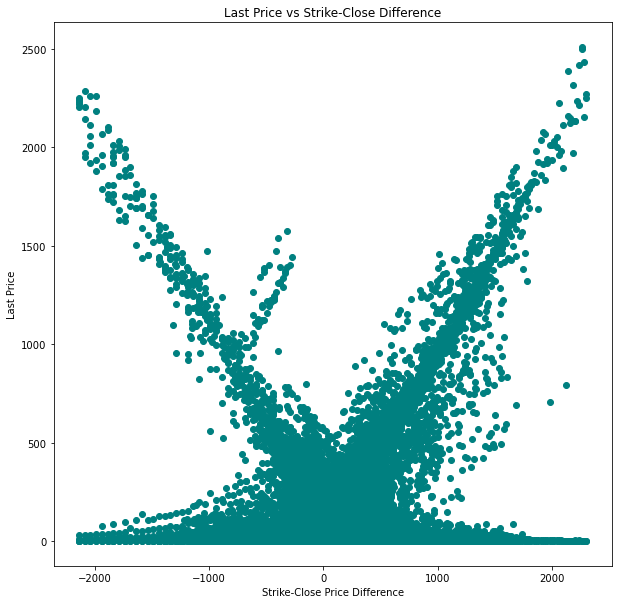

In [26]:
# last price vs strike-close differnece at a glance
# this chart will be used later to point out anomolous data
ax = plt.figure(figsize=(10,10))
plt.scatter(cleaned_opts['stk_cls_diff'], cleaned_opts['lastPrice'], color='teal')
plt.title('Last Price vs Strike-Close Difference')
plt.xlabel('Strike-Close Price Difference')
plt.ylabel('Last Price')
plt.show()

---

# Anomoly Detection

---

## <div style="color:#957dad">Isolation Forest</div>

<div style="color:teal"><p>Chosen for anomoly detection amongst features in options data. Anomolies could potentially expose inefficiencies that may be taken advantage of through arbatrige trading.</br>
The features that will be included are: 
<ul>
<li>Moneyness</li>    
<li>impliedVolatility</li>
<li>time_to_exp</li>
<li>close</li>
<ul></p></div>

In [27]:
X_train  = cleaned_opts[['moneyness','impliedVolatility','time_to_exp','close','stk_cls_diff','lastPrice']]

In [28]:
clf = IsolationForest(max_samples='auto', contamination=.025, n_estimators=10, max_features=X_train.shape[1])

clf.fit(X_train)
y_pred_train = clf.predict(X_train)

In [29]:
cleaned_opts['pred'] = y_pred_train

In [30]:
cleaned_opts['pred'].value_counts()

 1    190444
-1      4880
Name: pred, dtype: int64

In [31]:
anomalies = cleaned_opts.loc[cleaned_opts['pred'] == -1]

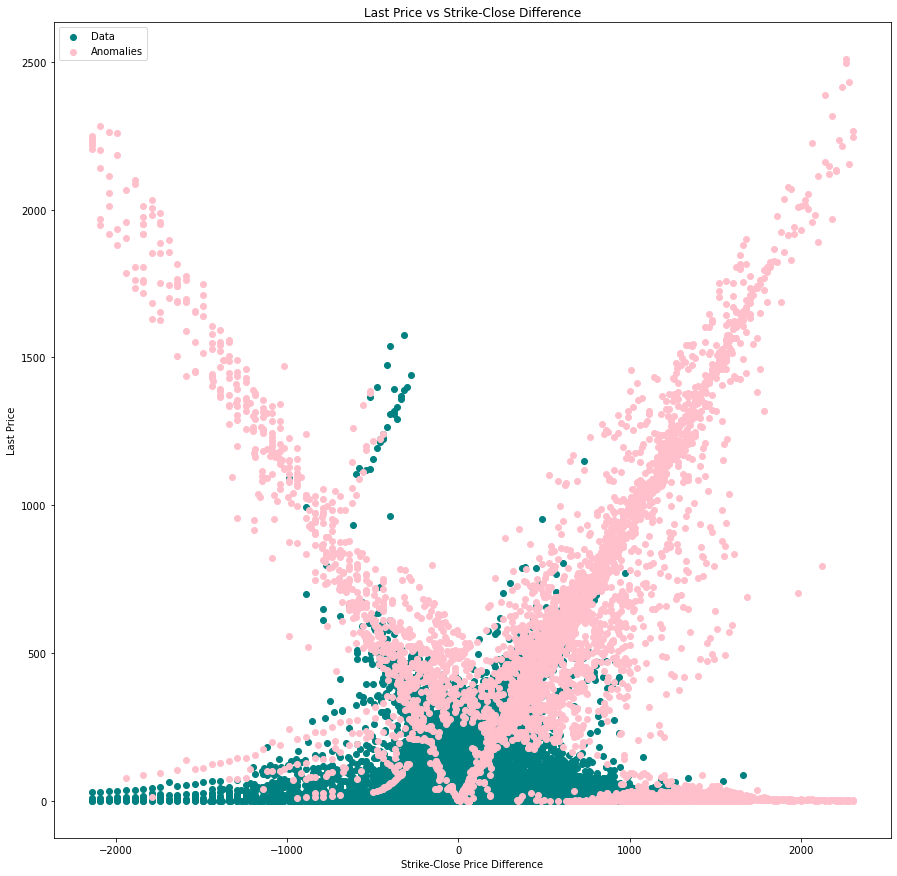

In [32]:
ax = plt.figure(figsize=(15,15))
# take the set difference between cleaned_opts and anomolies
diff = cleaned_opts[cleaned_opts.pred.isin(anomalies.pred) == False]
# plt.scatter(cleaned_opts['stk_cls_diff'], cleaned_opts['lastPrice'], color='teal')
plt.scatter(diff['stk_cls_diff'], diff['lastPrice'], color='teal')
plt.title('Last Price vs Strike-Close Difference')
plt.xlabel('Strike-Close Price Difference')
plt.ylabel('Last Price')
plt.scatter(anomalies['stk_cls_diff'], anomalies['lastPrice'], color='pink')
plt.legend(['Data','Anomalies'])
plt.show()

<p>The data that is high on the y-axis or far outside of zero (higher than 600 or lower than 1000) is somewhat expected to be anomolous data. The interesting anomolies are the ones within the high density areas for the normal data. Investigation of these points may yield some interesting insights.</p>

In [33]:
anomalies.describe()

,lastPrice,volume,impliedVolatility,call,time_to_exp,close,moneyness,stk_cls_diff,bs_theory,pred
count,4880.000000,4880.000000,4880.000000,4880.000000,4880.000000,4880.000000,4880.000000,4880.000000,4880.000000,4880.0
mean,500.909945,6.626025,0.926542,0.581352,282.751844,2109.499129,2.801360,560.633658,538.277837,-1.0
std,493.870603,26.621648,2.564077,0.493388,227.071220,1031.455687,8.963717,789.665247,515.751552,0.0
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.560000,0.008138,-2139.000000,0.000000,-1.0
25%,24.867500,1.000000,0.260412,0.000000,78.000000,1510.500000,0.744441,48.427502,20.736519,-1.0
50%,408.575000,2.000000,0.398733,1.000000,295.000000,2137.750000,1.370353,630.140015,448.110502,-1.0
75%,736.287500,4.000000,0.660190,1.000000,442.000000,3161.000000,2.009463,1169.780029,850.376081,-1.0
max,2508.600000,750.000000,97.000002,1.000000,1814.000000,3161.000000,371.640015,2301.000000,2423.812213,-1.0


In [34]:
diff.describe()

,lastPrice,volume,impliedVolatility,call,time_to_exp,close,moneyness,stk_cls_diff,bs_theory,pred
count,190444.000000,190444.000000,190444.000000,190444.0000,190444.000000,190444.000000,190444.000000,190444.000000,190444.000000,190444.0
mean,20.260115,63.485891,0.827407,0.5519,139.227363,249.326221,1.046728,11.392264,21.263000,1.0
std,50.794776,728.799213,0.874759,0.4973,174.337888,538.579888,0.682105,130.135431,52.894941,0.0
min,0.010000,1.000000,0.000000,0.0000,0.000000,0.560000,0.002691,-2139.000000,0.000000,1.0
25%,0.810000,1.000000,0.409918,0.0000,15.000000,26.809999,0.739714,-9.740000,0.797668,1.0
50%,4.000000,3.000000,0.598530,1.0000,78.000000,86.150002,0.941393,1.350000,4.017495,1.0
75%,16.200000,13.000000,0.960938,1.0000,197.000000,206.089996,1.137778,19.299988,16.555369,1.0
max,1576.000000,121842.000000,32.000005,1.0000,1814.000000,3161.000000,28.700001,1662.459961,1066.413401,1.0
